# ARIMA forecast for Coronavirus confirmed cases volume

## Dataset

I will analyze and forecast coronavirus confirmed cases volume all over the world. Epidemy started in Wuhan in December 2019. On 2/11/2020, the virus is officially named COVID-19 by the World Health Organization.
Data comes from: https://github.com/CSSEGISandData/COVID-19.

First we need to transform our dataset into series object containing date and comfirmed cases volumes.

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df = df.fillna('unknow')
df.head()

Province/State  Country/Region      Lat  ...  2/25/20  2/26/20  2/27/20
0          Anhui  Mainland China  31.8257  ...      989      989      989
1        Beijing  Mainland China  40.1824  ...      400      400      410
2      Chongqing  Mainland China  30.0572  ...      576      576      576
3         Fujian  Mainland China  26.0789  ...      294      294      296
4          Gansu  Mainland China  36.0611  ...       91       91       91

[5 rows x 41 columns]

In [52]:
df = df.append(df.sum(numeric_only=True), ignore_index=True)
df

Province/State  Country/Region         Lat  ...  2/25/20  2/26/20  2/27/20
0            Anhui  Mainland China    31.82570  ...    989.0    989.0    989.0
1          Beijing  Mainland China    40.18240  ...    400.0    400.0    410.0
2        Chongqing  Mainland China    30.05720  ...    576.0    576.0    576.0
3           Fujian  Mainland China    26.07890  ...    294.0    294.0    296.0
4            Gansu  Mainland China    36.06110  ...     91.0     91.0     91.0
..             ...             ...         ...  ...      ...      ...      ...
101         unknow         Denmark    56.26390  ...      0.0      0.0      1.0
102         unknow         Estonia    58.59530  ...      0.0      0.0      1.0
103         unknow     Netherlands    52.13260  ...      0.0      0.0      1.0
104         unknow      San Marino    43.94240  ...      0.0      0.0      1.0
105            NaN             NaN  3386.46002  ...  80415.0  81397.0  82756.0

[106 rows x 41 columns]

In [56]:
df = df.iloc[df.shape[0] - 1][4:df.shape[1]]
df

1/22/20      555
1/23/20      653
1/24/20      941
1/25/20     1434
1/26/20     2118
1/27/20     2927
1/28/20     5578
1/29/20     6166
1/30/20     8234
1/31/20     9927
2/1/20     12038
2/2/20     16787
2/3/20     19881
2/4/20     23892
2/5/20     27636
2/6/20     30818
2/7/20     34392
2/8/20     37121
2/9/20     40151
2/10/20    42763
2/11/20    44803
2/12/20    45222
2/13/20    60370
2/14/20    66887
2/15/20    69032
2/16/20    71226
2/17/20    73260
2/18/20    75138
2/19/20    75641
2/20/20    76199
2/21/20    76843
2/22/20    78599
2/23/20    78985
2/24/20    79570
2/25/20    80415
2/26/20    81397
2/27/20    82756
Name: 105, dtype: object

As our series object is ready, we will split it into two, one for model development (dataset.csv) and the other for validation - last week(validation.csv)


In [57]:
split_point = len(df) - 7
dataset, validation = df[0:split_point], df[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv', header = False)
validation.to_csv('validation.csv', header = False)

Dataset 30, Validation 7


## Persistence

The first step before getting bogged in modeling is to establish a baseline of performance. This will provide a performance measure by which all more elaborate predictive models can be compared. Persistence is where the observation from the previous step is used as the prediction for the observation at the next time step

In [58]:
from sklearn.metrics import mean_squared_error
from math import sqrt
# load data
series = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	yhat = history[-1]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=27636.000, Expected=30818
>Predicted=30818.000, Expected=34392
>Predicted=34392.000, Expected=37121
>Predicted=37121.000, Expected=40151
>Predicted=40151.000, Expected=42763
>Predicted=42763.000, Expected=44803
>Predicted=44803.000, Expected=45222
>Predicted=45222.000, Expected=60370
>Predicted=60370.000, Expected=66887
>Predicted=66887.000, Expected=69032
>Predicted=69032.000, Expected=71226
>Predicted=71226.000, Expected=73260
>Predicted=73260.000, Expected=75138
>Predicted=75138.000, Expected=75641
>Predicted=75641.000, Expected=76199
RMSE: 4762.793


The example ends by printing the RMSE for the model. We can see that the persistence model achieved 4762. This means that on average, th model was wrong by about 4762 confirmed coronavirus cases for each prediction made.

## Summary Statistics

In [59]:
series.describe()

count       30.000000
mean     32726.333333
std      27404.739690
min        555.000000
25%       6683.000000
50%      29227.000000
75%      56583.000000
max      76199.000000
Name: 1, dtype: float64

Running the example provides a number of statistics to review:

*   The mean is about 32726, which we might consider our level in this series
*   The standard deviation (average spread from the mean) is relatively large at 27405 cases.
*   The percentiles along ith the standard deviation suggest a large spread to the data





## Line and density plots

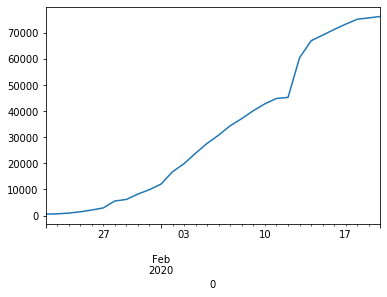

In [60]:
series.plot()

*   There is increasing trend over time which means that the dataset is non-stationary



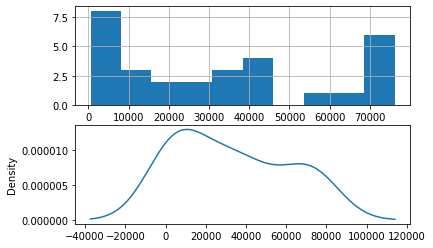

In [65]:
plt.figure(1)
plt.subplot(211)
series.hist()
plt.subplot(212)
series.plot(kind='kde')
plt.show()



*   The distribution is not Gaussian
*   The distribution is left shifted and may be exponential or double Gaussian



## Manually cofigured ARIMA

ARIMA(p, d, q) requires 3 parameters and is traditionally configured manually. We will try to *guess* probable values, starting from *d*.

The time series is non-stationary. We can make it stationary by differencing the series.

In [62]:
from statsmodels.tsa.stattools import adfuller

# create a differenced time series
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return pd.Series(diff)

# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# save
stationary.to_csv('stationary.csv', header = False)

ADF Statistic: -4.047979
p-value: 0.001179
Critical Values:
	1%: -3.689
	5%: -2.972
	10%: -2.625


Running an example outputs the result of statistical significance test of whether the 1-lag differenced series is stationary. Specifically, the augmented Dickey-Fuller test. The results show that te test static value -4.048 is smaller than the critical value at 5% of -2.972. This suggests we can reject null hypothesis and conclude that 1-lag differenced series is stationary. Then at least one level of differencing is required.  *d* >= 1

The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, *p* and *q* respectively. We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF).

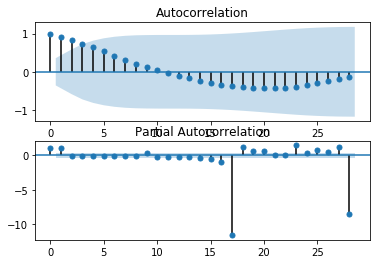

In [67]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(series, lags=28, ax=plt.gca())
plt.subplot(212)
plot_pacf(series, lags=28, ax=plt.gca())
plt.show()



*   The ACF shows significant lag for 1-3 months
*   The PACF does not show a significant lag

Good starting point will be p = 1 and q = 0




# Grid search for ARIMA

We will use a grid search to explore all combinations of the ARIMA parameters and find the best one.

In [64]:
import warnings
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	rmse = sqrt(mean_squared_error(test, predictions))
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					rmse = evaluate_arima_model(dataset, order)
					if rmse < best_score:
						best_score, best_cfg = rmse, order
					print('ARIMA%s RMSE=%.3f' % (order,rmse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# evaluate parameters
p_values = range(0,13)
d_values = range(0, 4)
q_values = range(0, 13)
warnings.filterwarnings("ignore")
evaluate_models(X, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=37893.968
ARIMA(0, 0, 1) RMSE=19339.975
ARIMA(0, 1, 0) RMSE=3693.126
ARIMA(0, 1, 1) RMSE=3842.899
ARIMA(0, 2, 0) RMSE=4715.540
ARIMA(0, 2, 1) RMSE=4442.390
ARIMA(1, 0, 0) RMSE=4831.500
ARIMA(1, 1, 0) RMSE=3969.514
ARIMA(1, 2, 0) RMSE=4869.999
ARIMA(2, 0, 0) RMSE=4402.898
Best ARIMA(0, 1, 0) RMSE=3693.126


# Review Residual Errors

A good final check is to review residual forecast errors. Ideally, the distribution should be Gaussian with a zero mean.

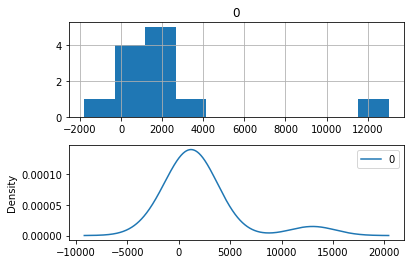

In [31]:
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(0,1,0))
	model_fit = model.fit(disp=0)
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = pd.DataFrame(residuals)
plt.figure()
plt.subplot(211)
residuals.hist(ax=plt.gca())
plt.subplot(212)
residuals.plot(kind='kde', ax=plt.gca())
plt.show()

## Validate Model

Now we can load the model and use it in a rolling - forecast manner, updating the transform and model for each time step. 

>Predicted=63088.864, Expected=66887
>Predicted=69771, Expected=69032
>Predicted=71885, Expected=71226
>Predicted=74052, Expected=73260
>Predicted=76056, Expected=75138
>Predicted=77900, Expected=75641
>Predicted=78322, Expected=76199
>Predicted=78807, Expected=76843
>Predicted=79385, Expected=78599
>Predicted=81116, Expected=78985
>Predicted=81435, Expected=79570
>Predicted=81964, Expected=80415
>Predicted=82763, Expected=81397
>Predicted=83706, Expected=82756
RMSE: 1776
>Predicted next day volume=85039


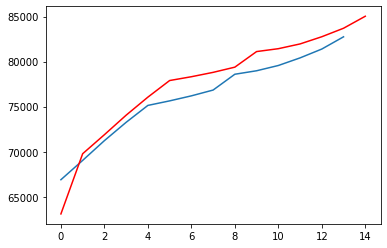

In [42]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import exp
from math import log
import numpy

# load and prepare datasets
dataset = pd.read_csv('dataset.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
X = dataset.values.astype('float32')
history = [x for x in X]
validation = pd.read_csv('validation.csv', header=None, index_col=0, parse_dates=True, squeeze=True)
y = validation.values.astype('float32')
# run model
model = ARIMA(history, order=(0,1,0))
model_fit = model.fit(disp=0)
# make first prediction
predictions = list()
yhat = model_fit.forecast()[0][0]
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
  # predict
  model = ARIMA(history, order=(0,1,0))
  model_fit = model.fit(disp=0)
  yhat = model_fit.forecast()[0][0]
  predictions.append(yhat)
  # observation
  obs = y[i]
  history.append(obs)
  print('>Predicted=%i, Expected=%i' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(y, predictions))
print('RMSE: %i' % rmse)
#predict next day
# predict
model = ARIMA(history, order=(0,1,0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0][0]
predictions.append(yhat)
print('>Predicted next day volume=%i' % (yhat))
plt.plot(y)
plt.plot(predictions, color='red')
plt.show()

Predicted number of confirmed coronavirus cases for 28.02.2020 is 85039. A plot of the predictions compared to validation dataset is also provided. The forecast has the characteristics of a presistence forecast. This suggests that although this time serie has obvious tred , it is still reasonably difficult problem. 

In the future data transforms (Box-Cox) could be tested.